# TO DO:
Make pretty:
- Tune images so they look nice
- Add comments to functions
- Add docstrings to functions
- Add markdown sections, titles, etc.
- make outputs pretty
- make functions for repeating code
- ...

## Importing libraries/modules

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

import utils
import feature_extraction

%load_ext autoreload
%autoreload 2

## Constants

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')

## Function for loading the data and extracting features in real time


In [111]:
@utils.cache_to_file_pickle("function-dataset_stats", cache_dir = CACHE_DIR)
def dataset_stats(data_dir, speaker_info_file_path):
    """Function for loading the Quotebank and speaker_attribute dataset, extract speakers informations and generating dictionaries containing the frequency for each feature.
    
    Params:
        data_dir::[str]
            Path of the Data directory.
        speaker_info_file_path::[str]
            Path for the speaker_attributes.parquet file.
            
    Returns:
        num_quotes_count::[int]
            Total number of quotes.
        num_occurrences_counts::[dict]
            Dictionary with keys the number of quotes and values the number of occurencies.
        speakers_dict::[DataFrame]
            DataFrame informations for each speaker:[quote_count, age, num_occurrences, genderoccupation, nationality, ethnic_group, religion.
    
    """
    
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = data_dir, speaker_info_file_path = speaker_info_file_path)
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, columns = ['id', 'date_of_birth', 'gender', 'occupation', 'nationality', 'ethnic_group', 'religion'])
    speaker_data = speaker_data.set_index('id').to_dict('index')
    
    # Initialization of dictionaries for extracting meaningfull features.
    num_quotes_count = 0
    num_occurrences_counts = {}
    speakers_dict = {}
    
    for line in utils.json_lines_generator(data_dir):        
        num_quotes_count += 1
        
        line_num_occurrences = line['numOccurrences']
        num_occurrences_counts[line_num_occurrences] = num_occurrences_counts.get(line_num_occurrences, 0) + 1
        
        # Solve ambiguities in speaker qids due to homonyms.
        speaker = feature_extraction.solve_ambiguous_speakers(line['qids'], linkcounts)
        
        # Calculate speaker age. In case of missing value the None value is added.
        speaker_birth_date = speaker_data.get(speaker, {}).get('date_of_birth', None)
        speaker_age = feature_extraction.get_speaker_age(speaker_birth_date, line['date'])
        
        # Add to the dict. the number of quotes, the age and the number of occurencies of the quotes for a speaker.
        # If there is a new speaker the dictionary is updated with the new informatins
        if speaker in speakers_dict:
            speakers_dict[speaker]['quote_count'] += 1
            speakers_dict[speaker]['age'].append(speaker_age)
            speakers_dict[speaker]['num_occurrences'] += line_num_occurrences
        else:
            speakers_dict[speaker] = {'quote_count': 1,
                                      'age': [speaker_age],
                                      'num_occurrences': line_num_occurrences}
            
        # Add to the dict. the qids for gender, occupation, nationality, ethnic group and religion for the different speaker.
        # In case of missing values, None is added to the dict.
            for info_key in ['gender', 'occupation', 'nationality', 'ethnic_group', 'religion']:
                speaker_value = speaker_data.get(speaker, {}).get(info_key, None)
                speaker_value_labels = []
                if speaker_value is not None:
                    for qid in speaker_value:
                        label = qid_labels.get(qid, None)
                        if label is not None:
                            speaker_value_labels.append(label)
                            
        # The qid are translated into their label.
                speaker_value_labels = speaker_value_labels if len(speaker_value_labels) != 0 else None
                speakers_dict[speaker][info_key] = speaker_value_labels
                
    # Since the dict. of speaker infos contains a list of age (in case of multiple quotes) we took the average of them.
    speakers_dict = pd.DataFrame(speakers_dict).T
    speakers_dict['age'] = speakers_dict['age'].apply(lambda l: None if all(elem is None for elem in l) else np.mean(l))
    
    return num_quotes_count, num_occurrences_counts, speakers_dict

# Load the Quotebank and speaker_attribute dataset, extract the relevant infos for each speaker and generate a dictionary containing meaningfull features.
num_quotes_count, num_occurrences_counts, speakers_info = dataset_stats(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)

### Data exploration

In [4]:
print(f"There are {num_quotes_count} quotes in this dataset")

There are 115584257 quotes in this dataset


In [18]:
speakers_info.head(10)

,quote_count,age,num_occurrences,gender,occupation,nationality,ethnic_group,religion
Q270316,4449,70.252416,23374,[Female],[Politician],[United States Of America],None,[Protestantism]
NaN,39988889,NaN,169373817,None,None,None,None,None
Q1253,13244,71.290094,101453,[Male],"[Politician, Diplomat]",[South Korea],[Koreans],"[Confucianism, Buddhism]"
Q468374,1076,60.941450,2905,[Male],[Guru],[India],None,[Hinduism]
Q19874690,212,56.750000,1562,[Male],[Physician],[Australia],None,[Sunni Islam]
Q18601741,14,NaN,16,[Male],[Musher],[United States Of America],None,None
Q5271548,594,78.186869,1622,[Female],"[Journalist, Historian, Blogger, Political Act...",[United States Of America],None,None
Q948687,6081,71.439566,16388,[Male],"[Television Presenter, Journalist, Writer]",[United States Of America],[Irish Americans],None
Q51797519,276,NaN,559,[Male],"[Sociologist, Criminologist]",None,None,None
Q2287947,17342,22.851055,140692,[Male],[Golfer],[United States Of America],None,None


In [99]:
print(f"For the {speakers_info.iloc[1]['quote_count']/num_quotes_count:.2%} of quotes we have no information about the speaker.")

For the 34.60% of quotes we have no information about the speaker.


### What is a Viral Quote?

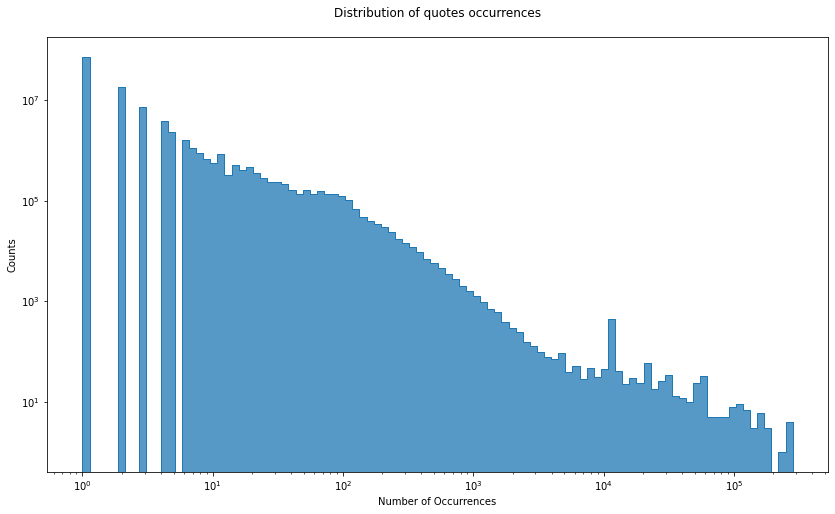

In [85]:
# Visualization of the distribution of number of occurences for each quote in the dataframe
plt.figure(figsize = (14, 8))
df_num_occurrences_counts = pd.DataFrame(num_occurrences_counts.items(), columns = ['Number of Occurrences', 'Count'])
sns.histplot(df_num_occurrences_counts, x = 'Number of Occurrences', weights = 'Count', bins = 100, log_scale = (True, True),element = "step");
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

#### Check if it's a Power Law

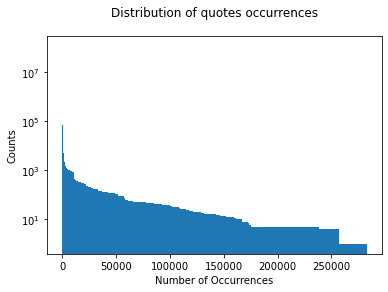

In [148]:
array_100 =plt.hist(df_num_occurrences_counts['Number of Occurrences'],weights=df_num_occurrences_counts['Count'],log=True, bins = 1000,cumulative=-1)
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

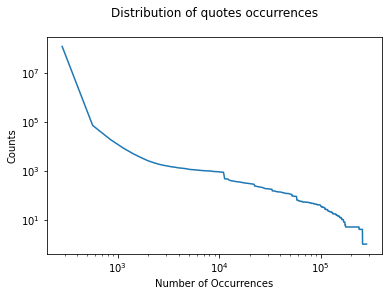

In [149]:
plt.loglog(array_100[1][1:],array_100[0])
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

#### IT'S A POWER LAW (MAYBE: CHECK)!

In [100]:
def describe_weighted_stats(values, weights, percentiles = []):
    
    values, weights = list(values), list(weights)
    
    stats = DescrStatsW(values, weights = weights, ddof = 0)
    stats_dict = {'count': stats.sum_weights, 'mean': stats.mean, 'std': stats.std, 'min': stats.quantile(0.).item()}
    
    for percentile in sorted([0.25, 0.5, 0.75] + percentiles):
        stats_dict[f'{100*percentile}%'] = stats.quantile(percentile).item()
    
    stats_dict['max'] = stats.quantile(1.).item()
    
    return stats_dict

In [101]:
describe_weighted_stats(num_occurrences_counts.keys(), 
                        num_occurrences_counts.values(),
                        percentiles = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999])

{'count': 115584257.0,
 'mean': 3.9926449672121005,
 'std': 113.83433159703256,
 'min': 1,
 '25.0%': 1,
 '50.0%': 1,
 '75.0%': 2,
 '95.0%': 10,
 '96.0%': 13,
 '97.0%': 17,
 '98.0%': 26,
 '99.0%': 55,
 '99.5%': 90,
 '99.9%': 215,
 'max': 282552}

In [9]:
# define a viral quotes has a quotes that has at least 100 occurencies
viral_thr = 100

num_cited_more_thr = sum(value for key, value in num_occurrences_counts.items() if key >= viral_thr)
num_cited_less_thr = sum(value for key, value in num_occurrences_counts.items() if key < viral_thr)

print(f"{num_cited_less_thr/(num_cited_less_thr + num_cited_more_thr):.3%} of quotes are quoted less than {viral_thr} times")
print(f"Quotes cited {viral_thr} times or more:", num_cited_more_thr)
print(f"Quotes cited less than {viral_thr} times:", num_cited_less_thr)

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


## Visualization of the features

In [147]:
def plot_weighted_distribution(df, feature, n_bars = 10, figsize = (15, 4), **plot_kwargs):    
    feature_titled = feature.replace('_', ' ').title()
    
    df = df[[feature, 'quote_count', 'num_occurrences']].rename(columns = {feature: feature_titled, 'quote_count': 'Quote Counts', 'num_occurrences': 'Number of Occurrences'})
    df.dropna(axis = 0, how = 'any', inplace = True)
    df.reset_index(drop = True, inplace = True)
        
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    
    if feature_titled == 'Age':
        
        for ax, weight_col in zip(axes, (None, 'Quote Counts', 'Number of Occurrences')):
            sns.histplot(data = df, x = feature_titled, weights = weight_col, ax = ax, **plot_kwargs)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)                
    else:
        value_counts = {}
        for _, row in df.iterrows():
            for value in row[feature_titled]:
                if value not in value_counts:
                    value_counts[value] = {'Not Weighted': 0, 'Quote Counts': 0, 'Number of Occurrences': 0}

                value_counts[value]['Not Weighted'] += 1
                value_counts[value]['Quote Counts'] += row['Quote Counts']
                value_counts[value]['Number of Occurrences'] += row['Number of Occurrences']
                
        for ax, weight_col in zip(axes, ('Not Weighted', 'Quote Counts', 'Number of Occurrences')):
            top_n_most_common = sorted(value_counts, key = lambda key: value_counts[key][weight_col], reverse = True)[:n_bars]
            
            sns.barplot(x = top_n_most_common, y = [value_counts[key][weight_col] for key in top_n_most_common], ax = ax, **plot_kwargs)
            ax.set_ylabel('Counts')
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)
        
    fig.suptitle(feature_titled + " Distribution")
    fig.tight_layout()

### Age

In [10]:
def plot_weighted_distribution(df, feature, n_bars = 10, figsize = (15, 4), **plot_kwargs):    
    feature_titled = feature.replace('_', ' ').title()
    
    df = df[[feature, 'quote_count', 'num_occurrences']].rename(columns = {feature: feature_titled, 'quote_count': 'Quote Counts', 'num_occurrences': 'Number of Occurrences'})
    df.dropna(axis = 0, how = 'any', inplace = True)
    df.reset_index(drop = True, inplace = True)
        
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    
    if feature_titled == 'Age':
        
        for ax, weight_col in zip(axes, (None, 'Quote Counts', 'Number of Occurrences')):
            sns.histplot(data = df, x = feature_titled, weights = weight_col, ax = ax, **plot_kwargs)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)                
    else:
        value_counts = {}
        for _, row in df.iterrows():
            for value in row[feature_titled]:
                if value not in value_counts:
                    value_counts[value] = {'Not Weighted': 0, 'Quote Counts': 0, 'Number of Occurrences': 0}

                value_counts[value]['Not Weighted'] += 1
                value_counts[value]['Quote Counts'] += row['Quote Counts']
                value_counts[value]['Number of Occurrences'] += row['Number of Occurrences']
                
        for ax, weight_col in zip(axes, ('Not Weighted', 'Quote Counts', 'Number of Occurrences')):
            top_n_most_common = sorted(value_counts, key = lambda key: value_counts[key][weight_col], reverse = True)[:n_bars]
            
            sns.barplot(x = top_n_most_common, y = [value_counts[key][weight_col] for key in top_n_most_common], ax = ax, **plot_kwargs)
            ax.set_ylabel('Counts')
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)
        
    fig.suptitle(feature_titled + " Distribution")
    fig.tight_layout()

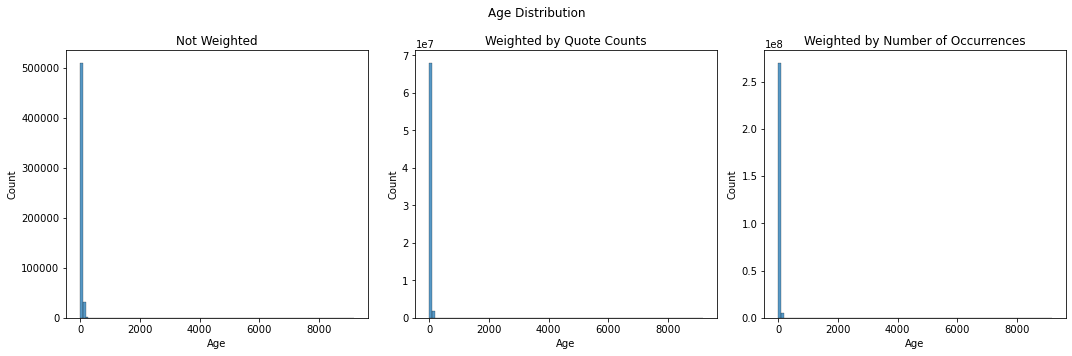

In [146]:
plot_weighted_distribution(speakers_info, 'age', bins = 100, figsize = (15, 5))

In [12]:
speakers_info['age'].describe()

count    543213.000000
mean         54.340948
std          50.028787
min          -4.909091
25%          36.000000
50%          52.000000
75%          67.000000
max        9168.277778
Name: age, dtype: float64

In [13]:
ages = speakers_info[['age', 'quote_count']].dropna()

print(f"{((ages['age'] < 5) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined")

0.00724% quotes have speaker for which gender couldn't be determined


In [14]:
print(f"{((ages['age'] > 95) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined")

1.05245% quotes have speaker for which gender couldn't be determined


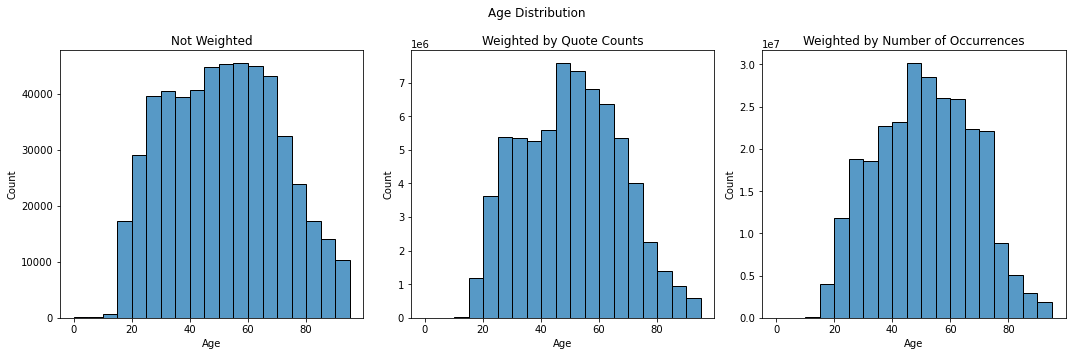

In [145]:
# Plot the Age distribution with no weigths, with weigths corresponding to the quote counts and with the weigths corresponding to the number of occurences of the quotes
plot_weighted_distribution(speakers_info, 'age', bins = range(0, 100, 5), figsize = (15, 5))

In [16]:
print(f"{(speakers_info['age'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which age couldn't be determined")

39.59676% quotes have speaker for which age couldn't be determined


We discard these ones as they do not interest us. Our main focus is towards people in politics or in the media currently which may be interested in knowing ways of improving their visibility. This does not apply to dead people nor very very young kids and may actually interfere with our language model.

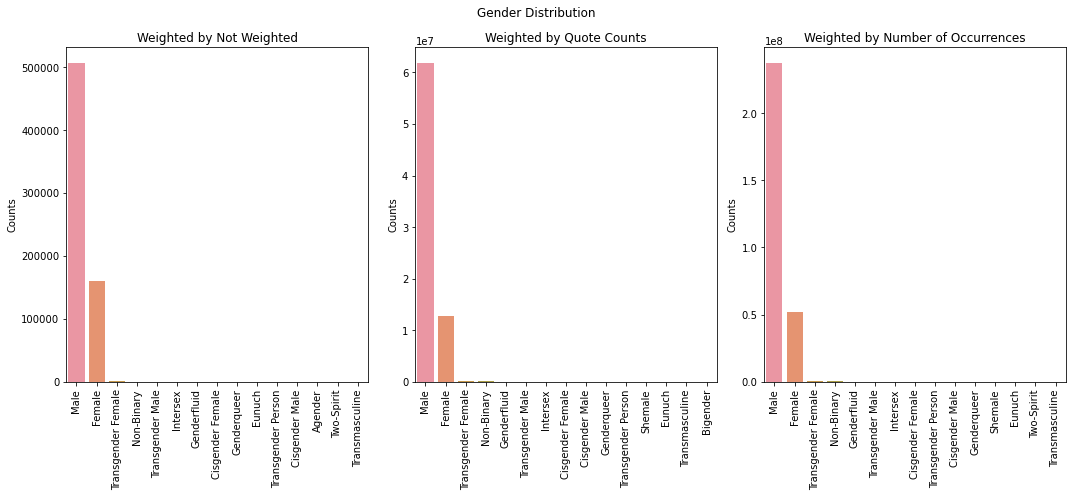

In [17]:
plot_weighted_distribution(speakers_info, 'gender', n_bars = 15, figsize = (15, 7))

In [18]:
print(f"{(speakers_info['gender'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined")

35.38079% quotes have speaker for which gender couldn't be determined


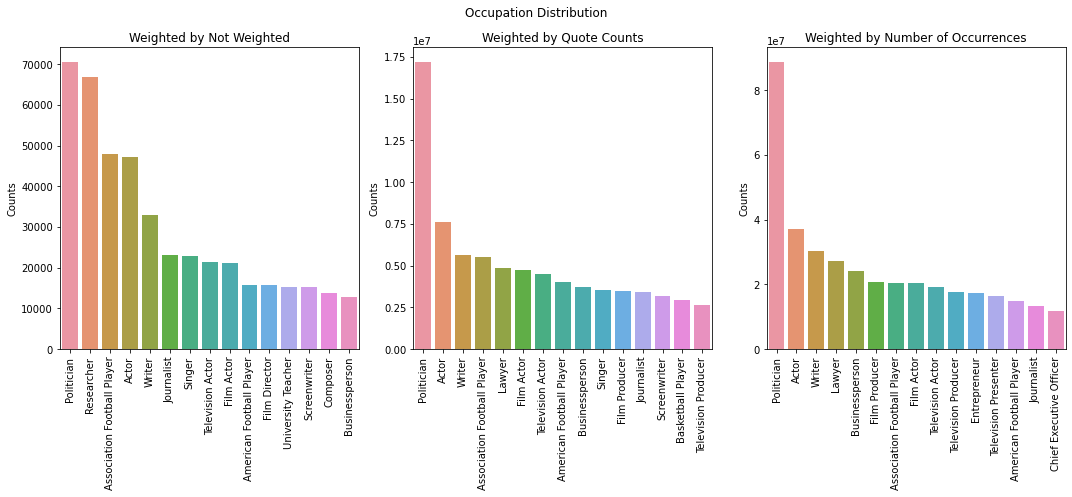

In [19]:
plot_weighted_distribution(speakers_info, 'occupation', n_bars = 15, figsize = (15, 7))

In [20]:
print(f"{(speakers_info['occupation'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which occupation couldn't be determined")

36.31932% quotes have speaker for which occupation couldn't be determined


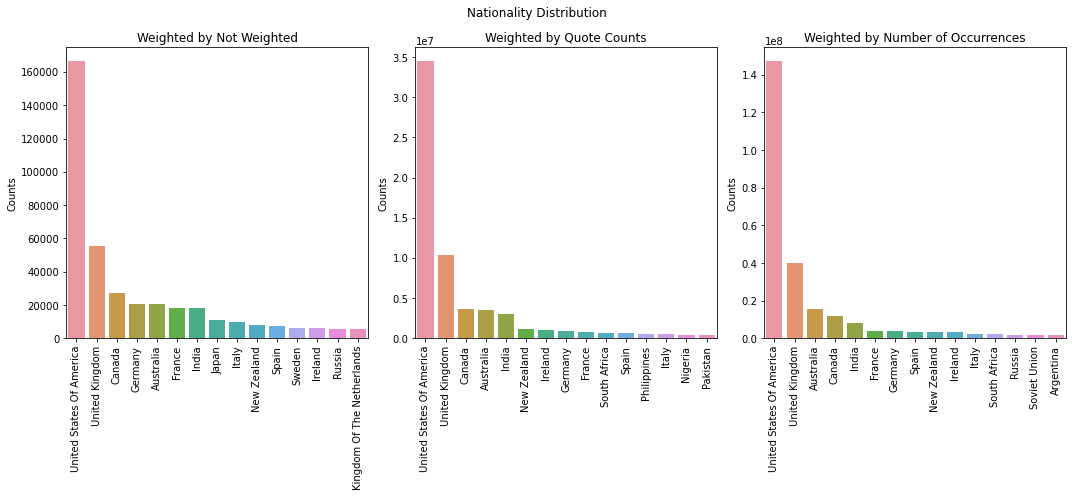

In [21]:
plot_weighted_distribution(speakers_info, 'nationality', n_bars = 15, figsize = (15, 7))

In [22]:
print(f"{(speakers_info['nationality'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which nationality couldn't be determined")

41.66662% quotes have speaker for which nationality couldn't be determined


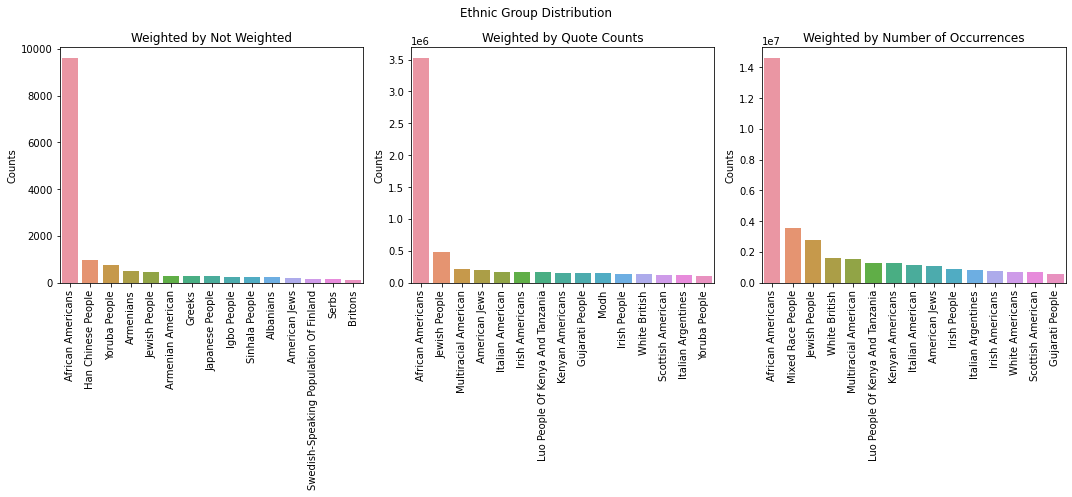

In [23]:
plot_weighted_distribution(speakers_info, 'ethnic_group', n_bars = 15, figsize = (15, 7))

In [24]:
print(f"{(speakers_info['ethnic_group'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which ethnic_group couldn't be determined")

93.97344% quotes have speaker for which ethnic_group couldn't be determined


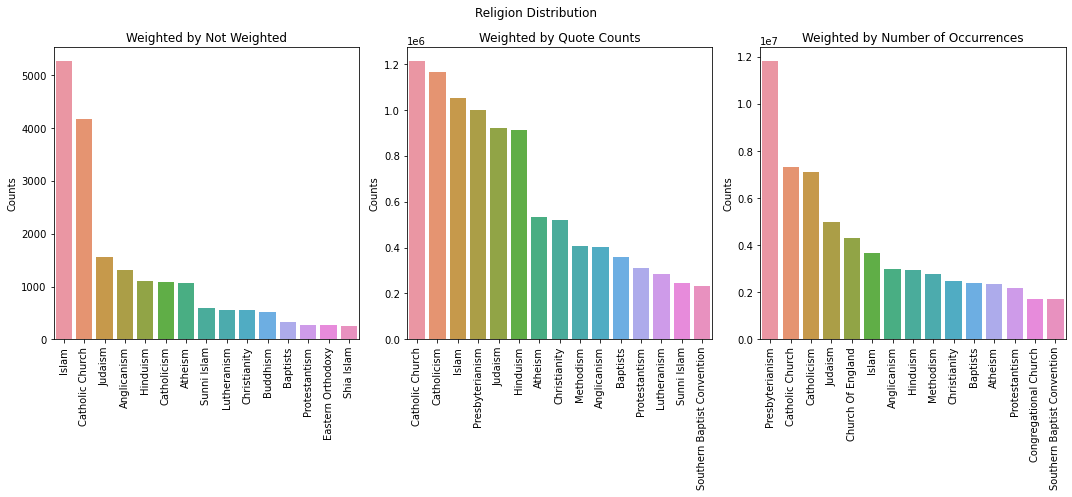

In [25]:
plot_weighted_distribution(speakers_info, 'religion', n_bars = 15, figsize = (15, 7))

In [26]:
print(f"{(speakers_info['religion'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which religion couldn't be determined")

90.28355% quotes have speaker for which religion couldn't be determined


In [27]:
features_we_are_going_to_use = ['age', 'gender', 'occupation']

print(f"{(speakers_info[features_we_are_going_to_use].isna().any(axis = 1) * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker information missing")

40.41783% quotes have speaker information missing
